Denoise MPD Backscatter data for comparison to other noise suppression techniques

In [10]:
import sys,os
import torch
import numpy as np
import matplotlib.pyplot as plt
import yaml
import importlib
import datetime
from matplotlib.colors import LogNorm
import time

import xarray as xr

In [2]:
# load file path information from the home directory
file_path_yml = os.path.join(os.environ["HOME"], ".ncar_config_derecho.yaml")
path_data = {}
with open(file_path_yml, "r") as r:
    path_data = yaml.safe_load(r)

In [3]:
dirP_str = os.path.join(
    path_data["ptv_collection_path"], "SpiralTorch", "python"
)
if dirP_str not in sys.path:
    sys.path.append(dirP_str)

In [4]:
from SpiralTorch import spiral
from SpiralTorch import loss

In [5]:
# use this block to autodetect if a GPU is available
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")
# device = torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True

print(f'Preparing to use device {device}')

dtype = torch.float64

Preparing to use device cuda:0


In [6]:
load_data_path = "/glade/derecho/scratch/mhayman/mpd-vae/datasets/"

In [8]:
data_file = os.path.join(load_data_path,"initial_30sec_test_mpd_data.nc")

In [9]:
ds = xr.open_dataset(data_file)

In [15]:
channel_list = ['WVOffline',]

Configure processing

In [16]:
fista_ver_str = 'jit-fista'  # 'cuda-fista', 'jit-fista'

In [121]:
tv_reg_dct = {
    # 'rho':np.array([1.0]),
    'rho':np.logspace(-0.5,0.5,10),
}

In [122]:
# create regularizer grid
tv_lst = []
for var in tv_reg_dct:
    tv_lst.append(tv_reg_dct[var])

tv_mesh_tup = np.meshgrid(*tv_lst)

grid_count = tv_mesh_tup[0].size

Define the forward model

In [123]:
# def laser_pulse(pulse_len,grid_res):
#     pulse = np.ones(int(np.ceil(pulse_len/grid_res)))
#     pulse[-1] = np.remainder(pulse_len,grid_res)/grid_res
#     return pulse.reshape(1,-1)

class mpd_backscatter:
    # def __init__(self,range_time_resolution:float):
    def __init__(self):
        # self.dt = range_time_resolution  #set the time resolution in the range axis
        # self.pulse_lst = []
        # self.pulse_length_lst = []
        # self.pulse_pad_lst = []
        self.bg_lst = []

    # def set_pulse_lengths(self,pulse_length_lst):
    #     self.pulse_lst = []
    #     self.pulse_length_lst = []
    #     self.pulse_pad_lst = []
        
    #     for pulse_len in pulse_length_lst:
    #         self.pulse_length_lst.append(pulse_len)
    #         self.pulse_lst.append(torch.tensor(laser_pulse(pulse_len,self.dt)[None,None,...],dtype=dtype,device=device))
    #         self.pulse_pad_lst.append(self.pulse_lst[-1].shape[-1]-1)

    def set_backgrounds(self,bg_lst):
        self.bg_lst = []
        for bg in bg_lst:
            self.bg_lst.append(torch.tensor(bg.squeeze()[:,None],dtype=dtype,device=device))
    
    def fwd_model_ch(self,ch_idx,**x):
        rho0 = torch.exp(x['rho'])
        rho_ch = rho0+self.bg_lst[ch_idx]
        fwd_mod_ch = {
            'y_mean_est':rho_ch
        }
        # rho_ch = torch.nn.functional.conv2d(rho0[None,None,...],
        #             self.pulse_lst[ch_idx],
        #             padding=(0,(self.pulse_pad_lst[ch_idx]))).squeeze()[:,:-self.pulse_pad_lst[ch_idx]]+self.bg_lst[ch_idx]
        # fwd_mod_ch = {
        #     'y_mean_est':rho_ch
        # }
        return fwd_mod_ch

        # use lambda x: model.fwd_model_ch(idx,x)
        # to define forward models for each channel

        
    def fwd_model_ch0(self,**x):
        return self.fwd_model_ch(0,**x)

    # def fwd_model_ch1(self,**x):
    #     return self.fwd_model_ch(1,**x)

In [124]:
# range resolution : np.mean(np.diff(ds['range'].values[load_idx,...]))

In [125]:
load_idx = 2  # scene index to load

In [126]:
# from ML notebook
bg_scale = 3.0  # needed for 3 thinned instances in data set
bg_lst = []
y_fit_dct_lst = []
y_val_dct_lst = []
for ch in channel_list:
    y_fit_dct_lst.append({'counts':ds[ch+'_thin0'].values[load_idx,...],})
    y_val_dct_lst.append({'counts':ds[ch+'_thin1'].values[load_idx,...],})
    # input_lst.append(ds[ch+'_thin0'].values[load_idx])
    # label_lst.append(ds[ch+'_thin1'].values[load_idx])
    bg_lst.append(ds[ch+'_bg'].values[load_idx,...]/bg_scale)

In [127]:
# mpd_model = mpd_backscatter(ds['range'].attrs['range_resolution']*2/mpd.c)
mpd_model = mpd_backscatter()
# mpd_model.set_pulse_lengths([1e-6,0.2e-6])
# bg_lst = []
# for ch in bg_total_dct:
#     bg_lst.append(bg_total_dct[ch]['rate'])

mpd_model.set_backgrounds(bg_lst)

In [128]:
fwd_model_lst = [
    mpd_model.fwd_model_ch0,
]

# y_fit_dct_lst = []
# y_val_dct_lst = []

# for idx, ch_str in enumerate(channel_list):
#     ch_mask = np.ones(ds_lst[0][ch_str+"_Uncorr"].values.shape)
#     ch_mask[:,:max_idx] = 0
#     ch_mask[:,-max_idx:] = 0
#     y_fit_dct_lst.append({'counts':ds_lst[0][ch_str+"_Uncorr"].values,})
#     y_val_dct_lst.append({'counts':ds_lst[1][ch_str+"_Uncorr"].values,})



In [129]:
# create spiral optimization object
spiral_opt = spiral.multiSpiral_autograd(device,dtype)  # these terms were set in the cell used to autodetect a GPU
spiral_opt.set_fista_version(fista_ver_str)  # set the FISTA version ('jit-fista' by default)
spiral_opt.set_fwd_model_lst(fwd_model_lst)  # load the forward models into the optimizer
spiral_opt.set_y_fit_lst(y_fit_dct_lst)   # load the fit data into the optimizer
spiral_opt.set_y_val_lst(y_val_dct_lst)   # load the validation data into the optimizer
spiral_opt.set_noise_model(['poisson',])  # set the noise model to be used for each channel (they don't have to be the same)

In [130]:
# check for alignment between observations and the noise model inputs
pass_test_bool, out_text, = spiral_opt.check_noise_model_inputs()
print(f"check passed: {pass_test_bool}")
print(out_text)

check passed: True
fit data is does not have a dictionary entry for optional input channel_mask in channel 0
validation data is does not have a dictionary entry for optional input channel_mask in channel 0
fit data is does not have a dictionary entry for optional input channel_weight in channel 0
validation data is does not have a dictionary entry for optional input channel_weight in channel 0



In [131]:
sparsa_subprob_config_dct = {
    'rho':{
        'alpha_min':1e4,
        'alpha_max':1e20,
        'alpha':1,
    },
    }

In [132]:
# set the initial conditions
x0 = {
    'rho':np.zeros(y_fit_dct_lst[0]['counts'].shape)+np.log(100),
}

In [133]:
# set the variables to be estimated (and order in which they are optimizers)
spiral_opt.set_estimate_lst(['rho'])

# this is where the subproblems for each variable get created, so there needs to be an entry for each
spiral_opt.add_sparsa_config(sparsa_subprob_config_dct)
spiral_opt.set_initial_conditions(x0)
# spiral_opt.set_tv_penalties({'beta':1e0,'d':1e1})  # this must happen after the subproblem is defined
spiral_opt.verbose = False

In [134]:
start_time = time.time()
x_sol_lst = []
vld_loss_lst = []
opt_time_lst = []
for idx in range(grid_count):
    tv_dct = {}
    for var_idx, var in enumerate(tv_reg_dct):
        tv_dct[var] = tv_mesh_tup[var_idx].flatten()[idx]
        print(var+f": {tv_mesh_tup[var_idx].flatten()[idx]}")
    spiral_opt.set_tv_penalties(tv_dct)  # this must happen after the subproblem is defined
    
    # reinitialize
    # spiral_opt.set_alpha(1.0)
    spiral_opt.set_initial_conditions(x0)
    
    # optimize
    spiral_opt.solve()

    # store result
    x_sol = spiral_opt.get_x()
    x_sol_lst.append(x_sol)
    vld_loss = spiral_opt.valid_loss()  # this is used for TV regularization optimization
    vld_loss_lst.append(vld_loss)
    opt_time_lst.append(spiral_opt.stop_time - spiral_opt.start_time)
    print(f"validation loss: {vld_loss}")
    print(f"optimization time: {opt_time_lst[-1]} seconds")
    print()

stop_time = time.time()

rho: 0.31622776601683794
validation loss: -2998605.4927927307
optimization time: 134.63824319839478 seconds

rho: 0.4084238652674521
validation loss: -2998797.04630054
optimization time: 135.22702550888062 seconds

rho: 0.5274997063702618
validation loss: -2998947.504896503
optimization time: 135.5174422264099 seconds

rho: 0.6812920690579612
validation loss: -2999043.629284413
optimization time: 135.0652084350586 seconds

rho: 0.8799225435691069
validation loss: -2999083.4541721833
optimization time: 134.1727809906006 seconds

rho: 1.1364636663857248
validation loss: -2999087.384718065
optimization time: 131.8582353591919 seconds

rho: 1.4677992676220695
validation loss: -2999066.666856488
optimization time: 133.79763865470886 seconds

rho: 1.8957356524063753
validation loss: -2999022.0715430668
optimization time: 133.4727065563202 seconds

rho: 2.448436746822227
validation loss: -2998956.276458862
optimization time: 132.2251842021942 seconds

rho: 3.162277660168379
validation loss: -

In [143]:
sol_idx = np.argmin(vld_loss_lst)
x_sol = x_sol_lst[sol_idx]

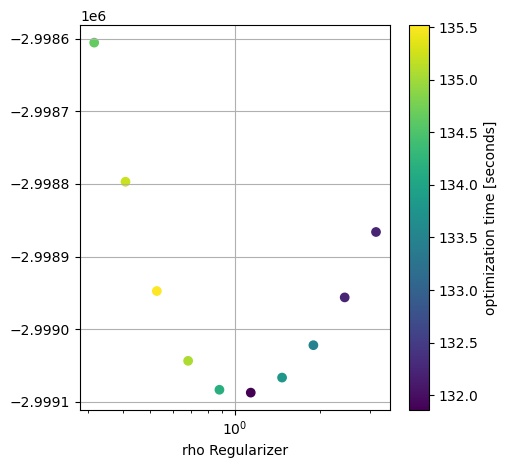

In [144]:
# # plot the regularizer search space
# # the lowest validation NLL is the best TV regularization

# for 2 or more regularizers, select which variables to plot (by index)
# var_idx_x = 0
# var_idx_y = 1

if len(tv_reg_dct.keys()) == 1:
    var_idx_x = 0
    tv_var_x = list(tv_reg_dct.keys())[var_idx_x]
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    im = ax.scatter(tv_mesh_tup[var_idx_x].flatten(),vld_loss_lst,c=opt_time_lst)
    ax.set_xlabel(tv_var_x + " Regularizer")
    ax.set_xscale('log')
    ax.grid(visible=True)
    plt.colorbar(im,ax=ax,label="optimization time [seconds]")
else:
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    tv_var_x = list(tv_reg_dct.keys())[var_idx_x]
    tv_var_y = list(tv_reg_dct.keys())[var_idx_y]
    
    im = ax.scatter(tv_mesh_tup[var_idx_x].flatten(),tv_mesh_tup[var_idx_y].flatten(),c=vld_loss_lst)
    ax.plot(tv_mesh_tup[var_idx_x].flatten()[sol_idx],tv_mesh_tup[var_idx_y].flatten()[sol_idx],'wx')
    ax.set_xlabel(tv_var_x + " Regularizer")
    ax.set_ylabel(tv_var_y + " Regularizer")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(visible=True)
    plt.colorbar(im,ax=ax,label="validation NLL")

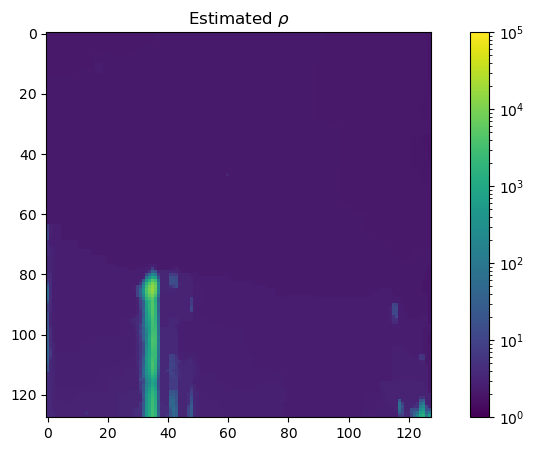

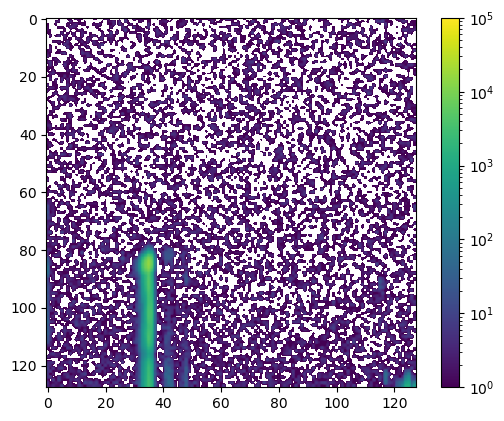

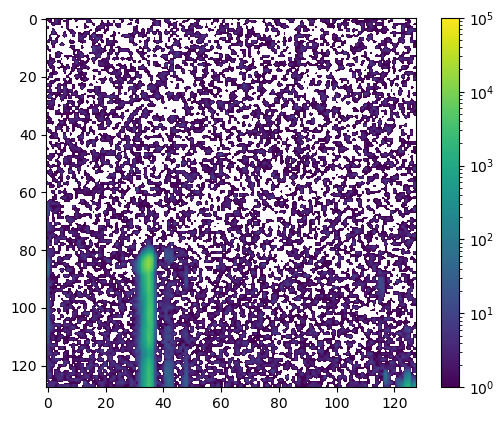

In [145]:
# plot the optimal solution and actual data (from the simulation) for comparison
plt_x_dct = {
    'rho':{'function':np.exp,
           'label':r'$\rho$',
           'units':'Hz',
           'description':'PTV Estimated backscatter flux from scene'},
}
clim_dct = {}

# fig,ax_lst = plt.subplots(1,len(x_act.keys()),figsize=(10,5))
# for var_idx, var in enumerate(x_act_test):
#     if len(x_act.keys()) == 1:
#         ax = ax_lst
#     else:
#         ax = ax_lst[var_idx]
#     im = ax[var_idx].imshow(x_act_test[var])
#     ax[var_idx].set_title(f"Actual "+plt_x_dct[var]['label'])
#     clim_dct[var] = im.get_clim()
#     plt.colorbar(im,ax=ax[var_idx])
    

fig,ax_lst = plt.subplots(1,len(x_sol.keys()),figsize=(10,5))
for var_idx, var in enumerate(x_sol):
    if len(x_sol.keys()) == 1:
        ax = ax_lst
    else:
        ax = ax_lst[var_idx]
        
    if 'function' in plt_x_dct[var]:
        plot_arr = plt_x_dct[var]['function'](x_sol[var])
    else:
        plot_arr = x_sol[var]
    im = ax.imshow(plot_arr[:,::-1].T,norm=LogNorm(vmin=1e0,vmax=1e5))
    ax.set_title(f"Estimated "+plt_x_dct[var]['label'])
    # im.set_clim(clim_dct[var])
    plt.colorbar(im,ax=ax)

plt.figure()
plt.imshow((y_val_dct_lst[0]['counts']-bg_lst[0][:,np.newaxis])[:,::-1].T,norm=LogNorm(vmin=1e0,vmax=1e5))
plt.colorbar()

plt.figure()
plt.imshow((y_fit_dct_lst[0]['counts']-bg_lst[0][:,np.newaxis])[:,::-1].T,norm=LogNorm(vmin=1e0,vmax=1e5))
plt.colorbar()

In [146]:
# calculate the forward model of the solution for each observation channel
fwd_model_dct_lst = []

x_sol_tnsr = {}

for var in x_sol:
    x_sol_tnsr[var] = spiral_opt.to_tensor(x_sol[var])

for idx, model in enumerate(spiral_opt.fwd_model_lst):
    y_est = model(**x_sol_tnsr)
    fwd_dct = {}
    for var in y_est:
        fwd_dct[var] = y_est[var].detach().cpu()
    fwd_model_dct_lst.append(fwd_dct)

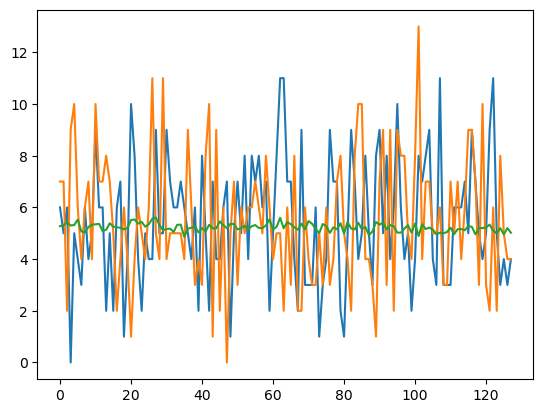

In [147]:
plt.figure()
plt.plot(y_val_dct_lst[0]['counts'][:,-1])
plt.plot(y_fit_dct_lst[0]['counts'][:,-1])
plt.plot(bg_lst[0])

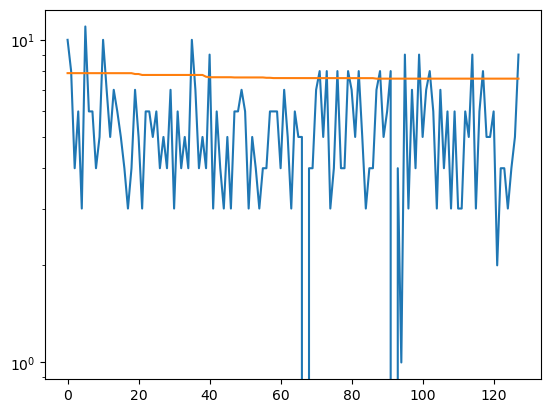

In [148]:
time_idx = 90
plt.figure()
plt.plot(y_val_dct_lst[0]['counts'][time_idx,:])
plt.plot(plot_arr[time_idx,:]+bg_lst[0][time_idx])
plt.yscale('log')